In [75]:
%matplotlib widget
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py, json
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid, get_clipped_array
from cupyx.scipy.ndimage import maximum_filter, median_filter, convolve1d
from signal_extraction import peristimulus_histogram, stimulus_correlation
from widgets import play_video_widget

from collections import defaultdict
import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import ortho_views_widget


In [2]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_rec = r"~/hpc-r/lfm2025/recordings/"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250828_1718_LB_zf552_para_f1_4"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)
# paths.registered = paths.registered[:-3]+"_prenorm.h5"
# paths.traces = paths.pn_outrec+"/traces_prenorm.h5"

### generate trace mask and stimulus file

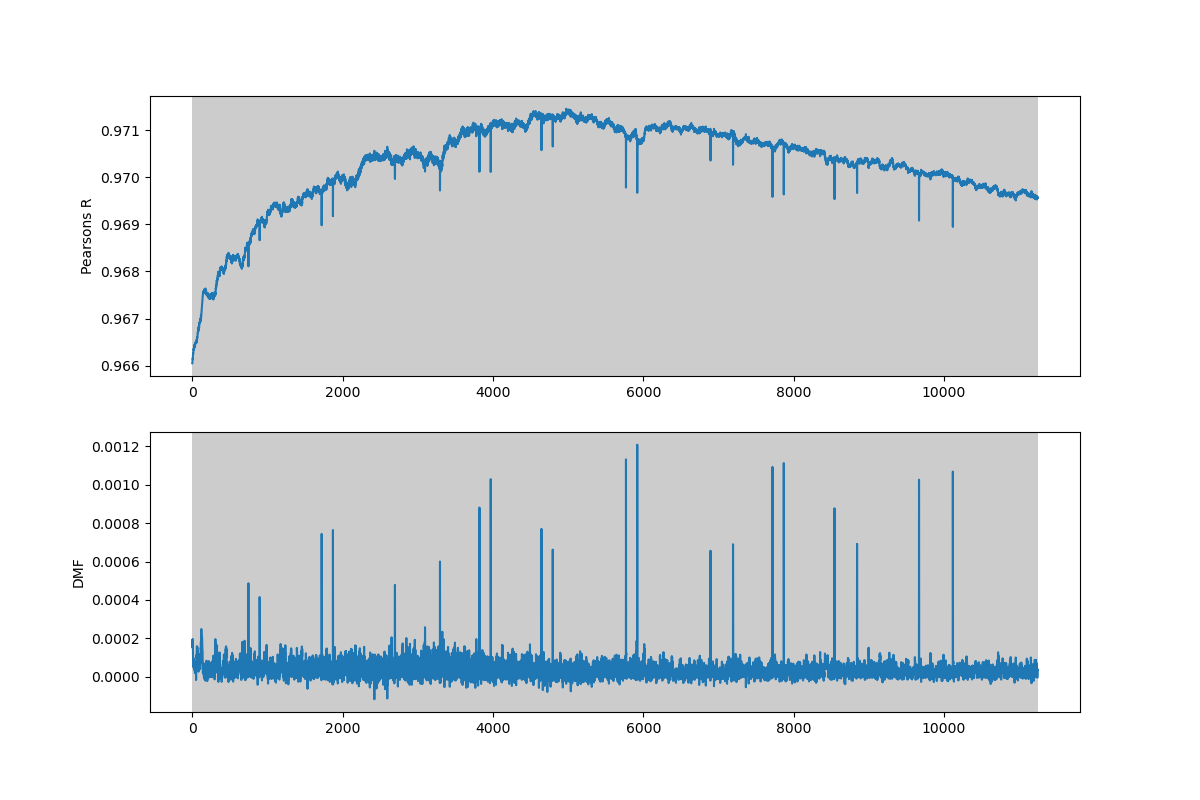

In [3]:
from cupyx.scipy.ndimage import maximum_filter, median_filter, convolve1d

r_thresh = 0.966
dmf_thresh = 0.0013

fig, axs = plt.subplots(2,1,figsize=(12,8))
ax = axs.flatten()

reg = lazyh5(paths.registered)
metrics = reg["metrics"].T
r = metrics[0]
ax[0].plot(r)
ax[0].set_ylabel("Pearsons R")
dmf =(maximum_filter(median_filter(cp.asarray(r), 3), size=21) - cp.asarray(r)).get()
ax[1].plot(dmf)
ax[1].set_ylabel("DMF")
trace_mask = np.ones_like(metrics[0], dtype = bool)
trace_mask[(dmf > dmf_thresh) | (r < r_thresh) | np.isnan(r)] = 0

neighbor_sum = convolve1d(cp.asarray(trace_mask).astype(cp.int8), weights=cp.array([1,1, 1]), mode='constant', cval=0).get()
trace_mask = trace_mask ^ ((trace_mask == True) & (neighbor_sum == 1))

diff = np.diff(np.concatenate(([False], trace_mask, [False])).astype(int))

# Find the start and end frame indices of each shaded region
starts_idx = np.where(diff == 1)[0]
ends_idx = np.where(diff == -1)[0]



for start, end in zip(starts_idx, ends_idx):
    # axvspan draws a vertical rectangle from start_time to end_time
    ax[0].axvspan(start,end, color='gray', alpha=0.4,zorder=0,linewidth=0  )
    ax[1].axvspan(start,end, color='gray', alpha=0.4,zorder=0,linewidth=0  )
# Redraw the figure to show the new spans
fig.canvas.draw()

In [5]:
trace_mask = np.ones(shape=(7219,))
trace_mask[1764:1796]=0
trace_mask[5322:5342]=0
trace_mask[7198:]=0
trace_mask = trace_mask.astype(bool)

In [60]:
stim_data = lazyh5(os.path.expanduser(os.path.join(stim_path, "stimdata_conditioned.h5")))
samplerate = stim_data["spec"]["samplerate"]
reverb_time = int(stim_data["spec"]["reverb_period"] * samplerate)

stimdict = {}
stim_names = {}
for i in range(len(stim_data["stimulus_collection"])):
    stimdict[i] = stim_data["stimulus_collection"][str(i)]["stimulus"]
    stim_names[i] = stim_data["spec"]["stimuli"][str(i)]["label"]

with open(os.path.expanduser(os.path.join(stim_path, "stimulus_assembly_info.json")), 'r') as f:
    stim_json = json.load(f)

stimulus_sequence_order = stim_json.get('stimulus_sequence_order', [])
assembly_info = stim_json.get('assembly_info', [])
total_duration = stim_json.get("assembly_duration", [])
final_stimulus = np.zeros(int(total_duration * samplerate))
final_stimulus_id = np.zeros(int(total_duration * samplerate))

for i, event_info in enumerate(assembly_info):
    stim_id = stimulus_sequence_order[i]
    if stim_id != 0:
        stim = stimdict[stim_id]
        if stim.shape[0]> 2*reverb_time:
            onset_time = round(event_info.get('onset') * samplerate)
            offset_time = round(event_info.get('offset') * samplerate)
            final_stimulus[onset_time:offset_time] = stim[reverb_time:-reverb_time]
            final_stimulus_id[onset_time:offset_time] = stim_id
        else:
            onset_time = round(event_info.get('onset') * samplerate)
            offset_time = onset_time+stim[reverb_time:].shape[0]
            final_stimulus[onset_time:offset_time] = stim[reverb_time:]
            final_stimulus_id[onset_time:offset_time] = stim_id

In [54]:
stimdict[2].shape

(8192,)

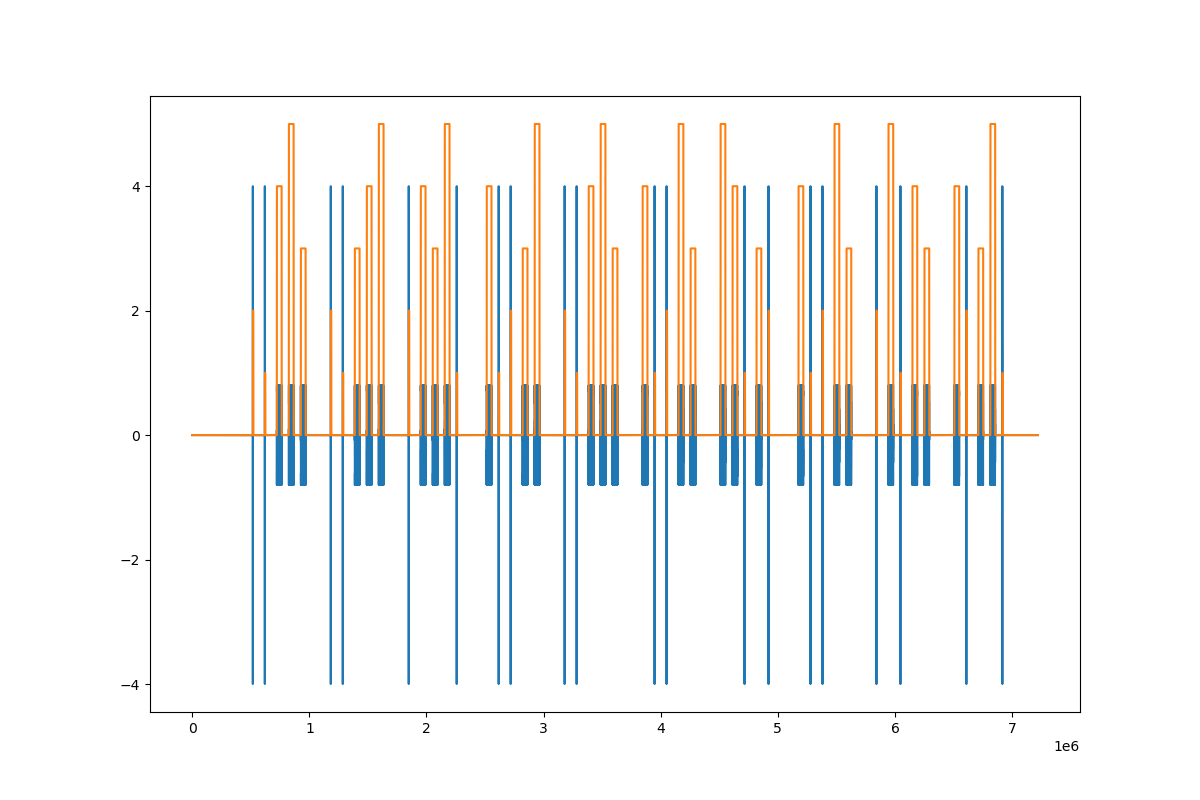

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(final_stimulus)
ax.plot(final_stimulus_id)


{0: 'Silence',
 1: '1pulse_1200Hz',
 2: '1pulse_1200Hz',
 3: 'sin_1200Hz',
 4: 'sin_800Hz',
 5: 'sin_2400Hz'}

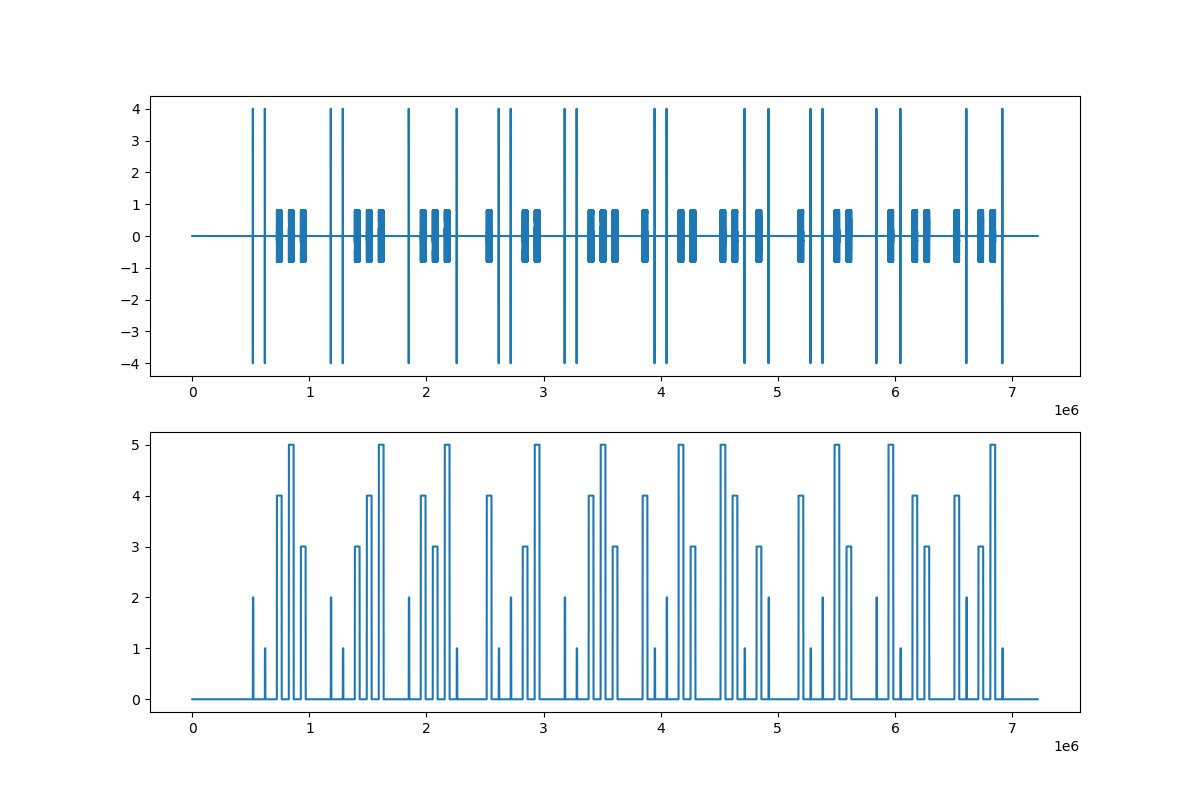

In [62]:
import i_o, importlib
importlib.reload(i_o)
from i_o import get_stimulus, parse_combinations

stim_path = os.path.expanduser(os.path.join(pn_rec, "stimset_LB_zf2"))

_, stim_names_og, stimulus_ids, final_stimulus, sr = get_stimulus(stim_path, fps = 75,)
    
fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(final_stimulus)
ax[1].plot(final_stimulus_id)
stim_names_og


(10586, 7)


{0: 'Silence',
 1: '1pulse_1200Hz',
 2: '1pulse_1200Hz',
 3: 'sin_1200Hz',
 4: 'sin_800Hz',
 5: 'sin_2400Hz',
 6: 'pulse'}

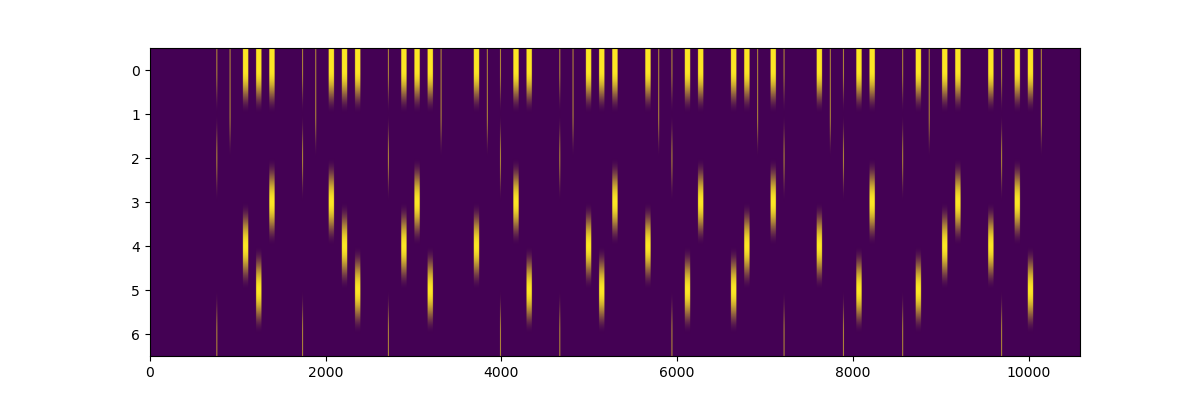

In [68]:
# combs = {
#     "R": "angle90.0",
#     "L": "angle270.0",
#     "400Hz": ("400Hz", "4e+02Hz"),  
#     "800Hz": ("800Hz", "8+02Hz"),  
#     "1200Hz": ("1200Hz", "1.2e+03Hz"),  
#     "R_gammatone": ["angle90.0", "gammatone"],  
#     "L_gammatone": ["angle270.0", "gammatone"],  
#     "R_sine": ["angle90.0", "gammatone"],  
#     "L_sine": ["angle270.0", "gammatone"],  
#     "R_400Hz": ["angle90.0", ("400Hz", "4e+02Hz")], 
#     "R_800Hz": ["angle90.0", ("800Hz", "8+02Hz")], 
#     "R_1200Hz": ["angle90.0", ("1200Hz", "1.2e+03Hz")], 
#     "L_400Hz": ["angle270.0", ("400Hz", "4e+02Hz")], 
#     "L_800Hz": ["angle270.0", ("800Hz", "8+02Hz")], 
#     "L_1200Hz": ["angle270.0", ("1200Hz", "1.2e+03Hz")], 
# }
combs = {"pulse": "pulse"}

combinations = parse_combinations(stim_names_og, combs)
bool_stim, stim_names, _, _, _ = get_stimulus(stim_path, fps = 75, combinations=combinations)
print(bool_stim.shape)
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.imshow(bool_stim[:,:].T, aspect="auto")
stim_names

### stimulus evoked activity

In [69]:
# traces = np.load(paths.pn_outrec + "/traces_prenorm_watershed.npy")
traces = np.array(lazyh5(paths.traces)["traces"])
segmentation = np.array(lazyh5(paths.traces)["segmentation"])

In [70]:
corr, sorted_indexes = stimulus_correlation(traces, bool_stim)

In [11]:
os.path.join(paths.pn_outrec, "stim_evoked")

'/home/lubo12/hpc-rw/lfm/results/20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1/stim_evoked'

In [71]:
bool_stim.shape

(10586, 7)

In [76]:
import imageio
fn = os.path.join(paths.pn_outrec, "stim_evoked/")
if not os.path.exists(fn):
    os.makedirs(fn)

images_for_video = []
for i in range(bool_stim.shape[1]):
    fig,ax = plt.subplots(1,1,figsize=(12,7))
    spatial_trace = np.zeros(corr.shape[1]+1, dtype = corr.dtype)
    spatial_trace[1:]=corr[i,:]
    volume = spatial_trace[segmentation]
    ax.imshow(create_projection_image(volume, transpose =True), cmap="gray")
    ax.set_title(stim_names[i])
     # Save figure to a buffer and append to list for video
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    images_for_video.append(image[:,:,:3]) # Convert from RGBA to RGB
    plt.close(fig)

# Create and save the video
video_path = os.path.join(fn, "components_wo_mask.mp4")
imageio.mimsave(video_path, images_for_video, fps=2)
play_video_widget(video_path)

WARNING (2025-09-02 20:18:59): IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 700) to (1200, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x555c26c4cec0] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [137]:
psth = peristimulus_histogram(traces, bool_stim, pad = 10)

Calculating correlation with stimulus:   0%|          | 0/28 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

for cells:   0%|          | 0/210593 [00:00<?, ?it/s]

In [134]:
psth.shape

(28, 210593, 56, 2)

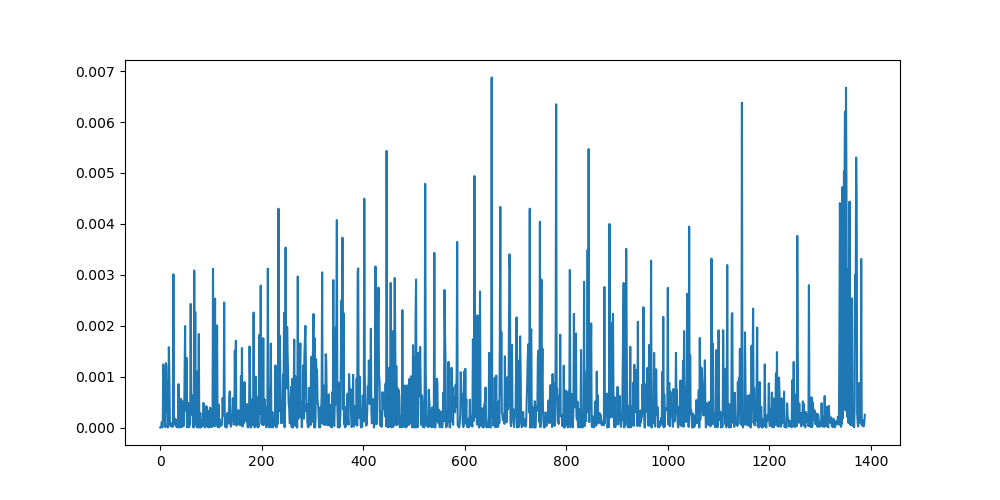

In [ ]:
spatial_trace = np.zeros(v.shape[1]+1, dtype = v.dtype)
    spatial_trace[1:]=v[i,:]
    volume = spatial_trace[segmentation]

### pca/ica analysis from aimon et al

In [20]:
traces_data = lazyh5(paths.traces)
traces = traces_data["traces"]
segmentation = traces_data["segmentation"]
traces_data

<IPython.core.display.JSON object>

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

traces_normalized = (traces - traces.mean(axis=0))/traces.std(axis=0)
print("traces normalized")
linked = linkage(traces_normalized.T, method='ward', metric='euclidean')
sort_order = dendrogram(linked, no_plot=True)['leaves']
traces_sorted = traces_normalized[:, sort_order]

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(traces_sorted.T, extent = [traces_sorted.shape[0]/40, 0, 0, traces_sorted.shape[1]], aspect="auto", cmap = "bwr")
ax.set_xlabel("Time")
ax.set_ylabel("ROIs")

traces normalized


<Axes: >

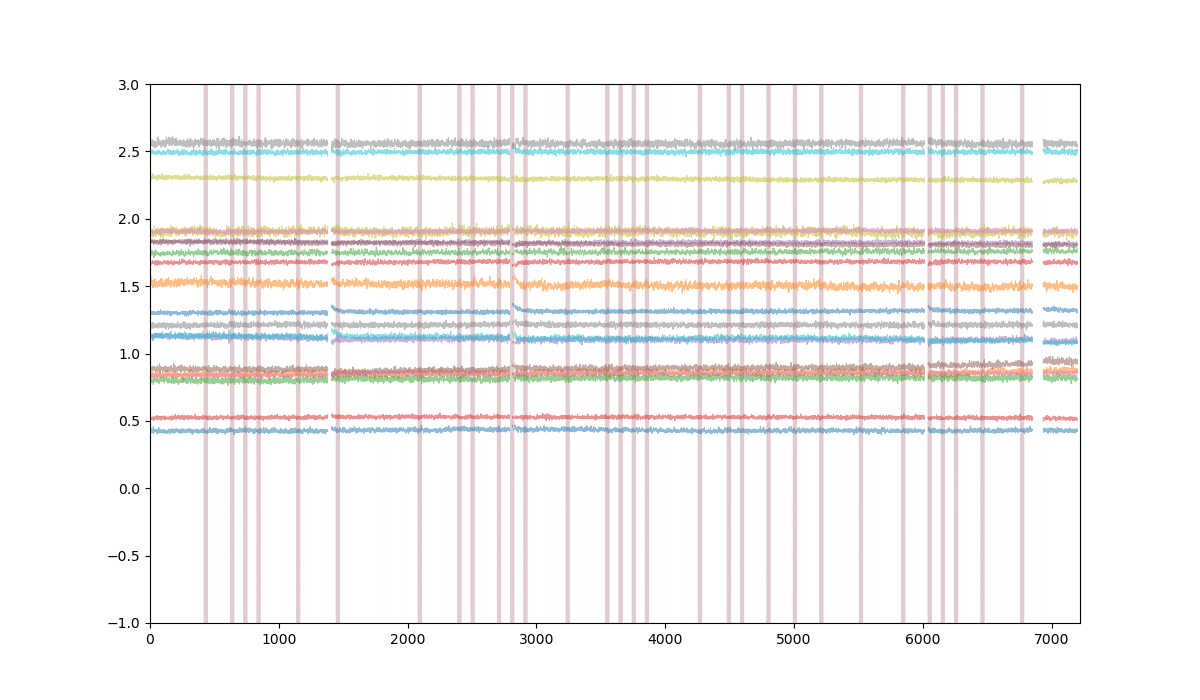

In [16]:
from util import plot_traces

idx = np.random.choice(np.arange(traces.shape[1]), 20)
fig, ax = plt.subplots(1,1,figsize=(12,7))
plot_traces(traces[:, idx], trace_mask ,stim_array = bool_stim, n=20,ax=ax, scale_factor = 0.1, y_add = 1)#

In [77]:
data = traces[trace_mask]

In [78]:
data -= data.mean(axis=0)

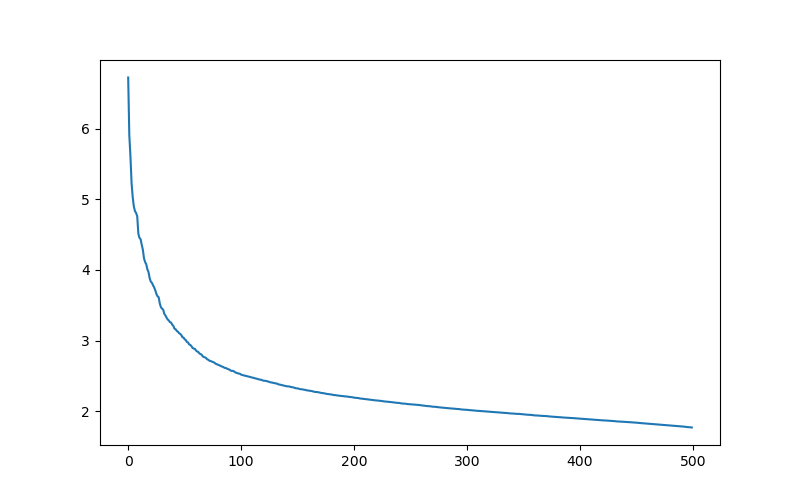

In [80]:
import nibabel as nib
from sklearn.decomposition import FastICA
from scipy.stats import zscore
from sklearn.utils.extmath import randomized_svd


normalization_threshold = 0.4
initial_components=60

# Initial SVD to capture main signal components
u, s, v = randomized_svd(data, n_components=initial_components, random_state=42)

s = np.diag(s)

# Soft thresholding to remove small fluctuations in component space
v[np.abs(v) < normalization_threshold*np.std(v)]=0

residual_std = np.maximum(np.std(data - (u @ s @ v), axis=0), 1)
data /= residual_std[np.newaxis, :]

#check_dimensionality
u, s, v = randomized_svd(data, n_components=500, random_state=42)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(np.log(s))
#choose the components where the curve deviates from the tail line

In [81]:
n_components = 150
u, s, v = randomized_svd(data, n_components=n_components, random_state=42)
s = np.diag(s)

In [82]:
from matplotlib.gridspec import GridSpec
import imageio
fn = os.path.join(paths.pn_outrec, "pca1")
if not os.path.exists(fn):
    os.makedirs(fn)

# The singular values from randomized_svd are already sorted in descending order.
# The explained variance is proportional to the square of the singular values.
s = np.diag(s)
explained_variance = s**2 / np.sum(s**2)

images_for_video = []
for i in tqdm(range(n_components)):
    fig = plt.figure(layout="constrained", figsize=(12,8))
    variance_percentage = explained_variance[i] * 100
    fig.suptitle(f'Component {i+1} (Variance: {variance_percentage:.2f}%)', fontsize=16)
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[0, :])
    
    # --- Plot 1: Temporal Trace ---
    temporal_trace = u[:, i]
    time_axis = np.arange(u.shape[0]) / 40
    ax0.plot(time_axis, temporal_trace)
    
    ax0.set_xlabel("Time (s)")
    ax0.set_ylabel("Amplitude")
    
    ax1 = fig.add_subplot(gs[1,0])
    # --- Plot 2: Power Spectrum ---
    # Calculate FFT and power spectrum for the temporal trace
    fft_vals = np.fft.fft(temporal_trace)
    power_spectrum = np.abs(fft_vals)**2
    freqs = np.fft.fftfreq(u.shape[0], d=1/40)
    
    # Plot only the positive frequencies
    positive_freq_mask = freqs >= 0
    ax1.plot(freqs[positive_freq_mask][1::4,], power_spectrum[positive_freq_mask][1::4,])
    ax1.set_title("Power Spectrum")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Power")
    ax1.set_yscale('log')
    # ax1.set_xscale('log')
    
    # reproject into spatial dimension
    ax2 = fig.add_subplot(gs[1,1:])
    
    spatial_trace = np.zeros(v.shape[1]+1, dtype = v.dtype)
    spatial_trace[1:]=v[i,:]
    volume = spatial_trace[segmentation]
    ax2.imshow(create_projection_image(volume, transpose =True), cmap="gray")
    
    # Save figure to a buffer and append to list for video
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    images_for_video.append(image[:,:,:3]) # Convert from RGBA to RGB
    plt.close(fig)

# Create and save the video
video_path = os.path.join(fn, "components_wo_mask.mp4")


imageio.mimsave(video_path, images_for_video, fps=2)

print(f"Video saved to {video_path}")

  0%|          | 0/150 [00:00<?, ?it/s]

[rawvideo @ 0x555d74009ec0] Stream #0: not enough frames to estimate rate; consider increasing probesize


Video saved to /home/lubo12/hpc-rw/lfm/results/20250828_1718_LB_zf552_para_f1_4/pca1/components_wo_mask.mp4
